## AutoEncoder

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

import os
from glob import glob
import pandas as pd

In [2]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 20

In [3]:
file_path = './back2/back2/*.jpg'
target_path = './scratch_data/scratch_data/*.jpg'

file_list = glob(file_path)
target_list = glob(target_path)

In [4]:
file_list = file_list[:50000]
target_list = target_list[:50000]

In [5]:
len(target_list)

50000

### DataLoader 생성

In [6]:
data_dict = {'train_path':[], 'target_path':[]}

for i in range(len(file_list)):
    train_path = file_list[i]
    target_path = target_list[i]
    
    data_dict['train_path'].append(train_path)
    data_dict['target_path'].append(target_path)

train_df = pd.DataFrame(data_dict)

train_df.to_csv("./train.csv", mode='w')

In [7]:
df = pd.read_csv('./train.csv')

In [8]:
from torchvision import transforms

transforms_train = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor()]
)

In [9]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class pair_Dataset(Dataset):
    def __init__(self, csv, mode, transform=None):
        self.csv = csv.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0] 

    def __getitem__(self, index):   
        row = self.csv.iloc[index]                
        train_image = Image.open(row.train_path).convert('RGB') 
        target_image = Image.open(row.target_path).convert('RGB')
        
        if self.transform:
            train_image = self.transform(train_image) # 이미지에 transform 적용하기
            target_image = self.transform(target_image)

        return train_image, target_image  # 이미지와 target return하기

In [12]:
# dataset class 객체 만들기
dataset_train = pair_Dataset(df, 'train', transform=transforms_train)

from torch.utils.data.sampler import RandomSampler
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,  num_workers=0)

In [13]:
len(train_loader)

500

### Encoder, Decoder

In [52]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, 16, 3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16, 32, 3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2, 2)
        )
        
        self.layer2 = nn.Sequential(
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(32, 32, 3, padding=1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = self.layer1(x)
        print(out.shape)
        out = self.layer2(out)
        print(out.shape)
        out = out.view(x.shape[0], -1)
        print(out.shape)
        return out


In [49]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(32, 32, 3,2, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32, 16, 3, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16, 16, 3, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16, 3, 3, 2, 1,1),
                        nn.ReLU()
        )


    def forward(self,x):
        out = x.view(x.shape[0],32,56,56)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

### model 생성

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 인코더 디코더의 파라미터를 동시에 학습시키기 위해 이를 묶는 방법입니다.
parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cuda:0


## Train

In [17]:
for i in tqdm(range(num_epoch)):
    for j,[train_img, target_img] in enumerate(train_loader):
      
        optimizer.zero_grad()
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        
        output = encoder(train_img)
        output = decoder(output)
        
        loss = loss_func(output, target_img)
        loss.backward()
        optimizer.step()
        
    torch.save(encoder.state_dict(), 'scratch_Encoder.pt')
    torch.save(decoder.state_dict(), 'scratch_Decoder.pt')

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [48:12<00:00, 144.65s/it]


In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder().to(device)

decoder.load_state_dict(torch.load('scratch_Decoder.pt'))
encoder.load_state_dict(torch.load('scratch_Encoder.pt'))

<All keys matched successfully>

In [76]:
from PIL import Image

test_image = Image.open('C:\\Users\\seojeongP\\Desktop\\2021\\영상처리와 딥러닝\\final_project\\back2\\back2\\55545.jpg').convert('RGB') 
test_target = Image.open('C:\\Users\\seojeongP\\Desktop\\2021\\영상처리와 딥러닝\\final_project\\scratch_data\\scratch_data\\55545.jpg').convert('RGB')

test_image = transforms_train(test_image).unsqueeze(dim=0).to(device)
test_target = transforms_train(test_target).to(device)

print(test_image.shape)
print(test_target.shape)

test_output = encoder(test_image)
test_output = decoder(test_output)

print(torch.squeeze(test_image).shape)

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 32, 112, 112])
torch.Size([1, 32, 56, 56])
torch.Size([1, 100352])
torch.Size([3, 224, 224])


In [77]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


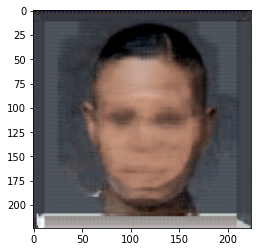

In [78]:
plt.imshow(torch.squeeze(test_output).cpu().detach().numpy().transpose(1, 2, 0))

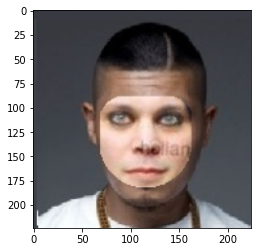

In [79]:
plt.imshow(torch.squeeze(test_target).cpu().detach().numpy().transpose(1, 2, 0))